In [1]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
	sys.path.append(nb_dir)

In [2]:
import torch
import torch.nn as nn
from torch.optim.radam import RAdam

import matplotlib.pyplot as plt
import random
from tqdm import trange

from general_utils import AttrDict
from reward_induced.src.reward_predictor_model import RewardPredictorModel, R_CLASSES_BASE
from sprites_datagen.moving_sprites import MovingSpriteDataset
from sprites_datagen.rewards import *


/home/thisiswooyeol/anaconda3/envs/2024Spring/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
spec = AttrDict(
        resolution=64,
        max_seq_len=30,
        max_speed=0.05,      # total image range [0, 1]
        obj_size=0.2,       # size of objects, full images is 1.0
        shapes_per_traj=4,      # number of shapes per trajectory
        rewards=[AgentXReward, AgentYReward, TargetXReward, TargetYReward],
    )

In [4]:
dataset = MovingSpriteDataset(spec)
dataset[0]['rewards']

{'agent_x': array([0.13501008, 0.17133477, 0.20765947, 0.24398416, 0.28030887,
        0.31663355, 0.35295826, 0.38928294, 0.42560765, 0.46193236,
        0.49825704, 0.5345817 , 0.57090646, 0.60723114, 0.6435558 ,
        0.67988056, 0.71620524, 0.7525299 , 0.7888546 , 0.82517934,
        0.861504  , 0.8978287 , 0.8658466 , 0.8295219 , 0.7931972 ,
        0.7568725 , 0.7205478 , 0.6842231 , 0.6478984 , 0.6115737 ],
       dtype=float32),
 'agent_y': array([0.23064317, 0.18865335, 0.14666353, 0.10467372, 0.1373161 ,
        0.17930591, 0.22129571, 0.26328555, 0.30527535, 0.34726515,
        0.389255  , 0.4312448 , 0.4732346 , 0.5152244 , 0.5572142 ,
        0.59920406, 0.64119387, 0.68318367, 0.7251735 , 0.7671633 ,
        0.80915314, 0.85114294, 0.89313275, 0.86487746, 0.82288766,
        0.7808978 , 0.738908  , 0.6969182 , 0.6549284 , 0.6129386 ],
       dtype=float32),
 'target_x': array([0.7416533 , 0.7549472 , 0.7682411 , 0.78153497, 0.7948289 ,
        0.80812275, 0.8214167 , 0.

# Train reward-induced representations with **RPM image encoder**

In [5]:
# some hyperparameters
image_shape = (3, 64, 64)
n_frames = 1   # number of conditioning frames
T_future = 29  # number of future frames to predict rewards for

lr = 1e-3
n_iter = 10_000
log_interval = 1_000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# # DEBUG - check computation graph of the model
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# from torchviz import make_dot

# model = RewardPredictorModel(image_shape, n_frames, T_future).to(device)
# image = dataset[0]['images']
# image = torch.tensor(image).to(device)
# pred_rewards = model(image[:n_frames].unsqueeze(0),
#                      image[n_frames:].unsqueeze(0))['agent_x']

# make_dot(pred_rewards, params=dict(model.named_parameters())).render('RPM_comp_graph', format='png')
# make_dot(pred_rewards, params=dict(model.named_parameters()), show_attrs=True, show_saved=True).render('RPM_comp_graph_back_prop', format='png')

In [7]:
def train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True):
	losses = []
	model.to(device)
	print(f'[INFO] Training complete reward predictor model on device: {device} ...')

	for itr in trange(n_iter):
		# always call `gen_trajectory` method regardless of `itr`
		data = dataset[itr]
		images = torch.tensor(data.images).to(device)
		rewards = {k: torch.tensor(v, dtype=torch.float32, device=device) for k, v in data.rewards.items()}

		# considering incomplete reward annotations
		reward_type_list = random.sample(R_CLASSES_BASE, k=3) if not is_complete else R_CLASSES_BASE

		# predict rewards with RPM
		pred_rewards = model(
			frames=images,
			reward_type_list=reward_type_list
		)

		# compute loss for each reward type
		loss = 0
		for reward_type, pred_reward in pred_rewards.items():
			reward = rewards[reward_type][-T_future:]
			loss += loss_fn(pred_reward, reward)

		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		losses.append(loss.item())
		if (itr+1) % log_interval == 0:
			print(f'[{itr+1} / {n_iter}] RPM loss: {loss.item()}')

	return losses

In [8]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

### (a) Train with complete reward annotation

In [9]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [10]:
losses_complete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=True)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1005/10000 [00:33<05:22, 27.85it/s]

[1000 / 10000] RPM loss: 0.20785579085350037


 20%|██        | 2003/10000 [01:06<04:07, 32.33it/s]

[2000 / 10000] RPM loss: 0.26572054624557495


 30%|███       | 3005/10000 [01:37<03:01, 38.50it/s]

[3000 / 10000] RPM loss: 0.15791276097297668


 40%|████      | 4003/10000 [02:08<04:27, 22.45it/s]

[4000 / 10000] RPM loss: 0.1274043172597885


 50%|█████     | 5005/10000 [02:35<02:16, 36.54it/s]

[5000 / 10000] RPM loss: 0.1763981133699417


 60%|██████    | 6004/10000 [03:03<01:51, 35.94it/s]

[6000 / 10000] RPM loss: 0.07979334890842438


 70%|███████   | 7006/10000 [03:30<01:16, 39.39it/s]

[7000 / 10000] RPM loss: 0.1076849102973938


 80%|████████  | 8004/10000 [03:56<00:50, 39.72it/s]

[8000 / 10000] RPM loss: 0.09306646883487701


 90%|█████████ | 9003/10000 [04:23<00:30, 32.87it/s]

[9000 / 10000] RPM loss: 0.1348920464515686


100%|██████████| 10000/10000 [04:50<00:00, 34.48it/s]

[10000 / 10000] RPM loss: 0.08672275394201279


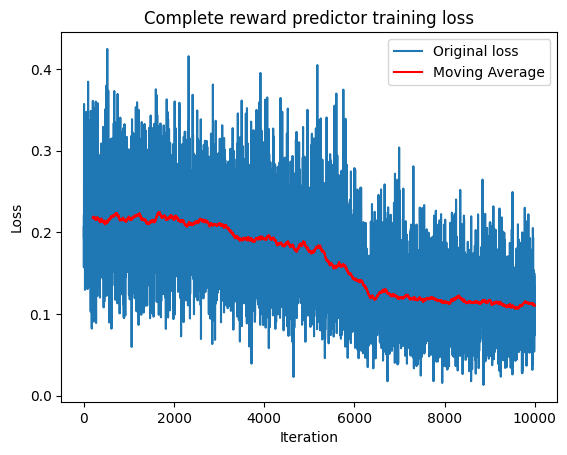

In [11]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Complete reward predictor training loss')
plt.legend()
plt.show()

In [12]:
PATH = 'models/complete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [13]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

### (b) Train with incomplete reward annotation

In [14]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
loss_fn = nn.MSELoss()

optimizer = RAdam(model.parameters(), lr=lr)

In [15]:
losses_incomplete_reward = train_RPM(model, dataset, loss_fn, optimizer, device, is_complete=False)

[INFO] Training complete reward predictor model on device: cuda ...


 10%|█         | 1004/10000 [00:26<04:29, 33.42it/s]

[1000 / 10000] RPM loss: 0.15597134828567505


 20%|██        | 2003/10000 [00:52<04:04, 32.74it/s]

[2000 / 10000] RPM loss: 0.11480176448822021


 30%|███       | 3006/10000 [01:18<03:02, 38.38it/s]

[3000 / 10000] RPM loss: 0.11784325540065765


 40%|████      | 4003/10000 [01:44<02:35, 38.62it/s]

[4000 / 10000] RPM loss: 0.010976355522871017


 50%|█████     | 5004/10000 [02:10<02:17, 36.37it/s]

[5000 / 10000] RPM loss: 0.005763606168329716


 60%|██████    | 6003/10000 [02:36<01:59, 33.36it/s]

[6000 / 10000] RPM loss: 0.08392321318387985


 70%|███████   | 7003/10000 [03:02<01:28, 33.97it/s]

[7000 / 10000] RPM loss: 0.0686158612370491


 80%|████████  | 8005/10000 [03:27<00:58, 33.99it/s]

[8000 / 10000] RPM loss: 0.18926388025283813


 90%|█████████ | 9008/10000 [03:53<00:23, 41.37it/s]

[9000 / 10000] RPM loss: 0.041991621255874634


100%|██████████| 10000/10000 [04:19<00:00, 38.50it/s]

[10000 / 10000] RPM loss: 0.061489373445510864


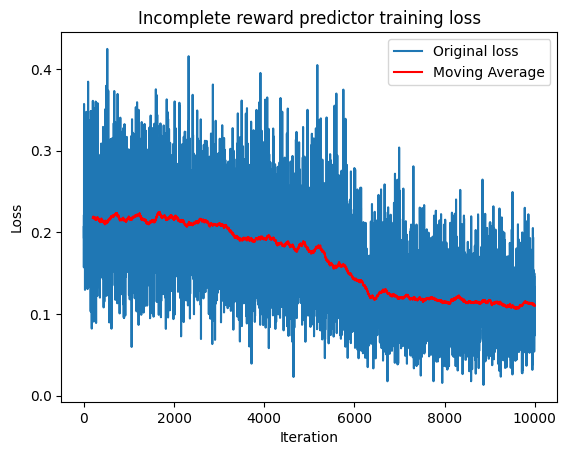

In [16]:
# Visualize the losses
window_size = 200
ma_losses = moving_average(losses_complete_reward, window_size)

plt.plot(losses_complete_reward, label='Original loss')
plt.plot(np.arange(window_size-1, len(ma_losses)+window_size-1), ma_losses, label='Moving Average', color='red')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Incomplete reward predictor training loss')
plt.legend()
plt.show()

In [17]:
PATH = 'models/incomplete_RPM_1e-3_1M.pth'
torch.save(model.state_dict(), PATH)

In [18]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load(PATH))  # test save and load

<All keys matched successfully>

# Test trained RPM

In [19]:
model = RewardPredictorModel(image_shape, n_frames, T_future)
model.load_state_dict(torch.load('models/complete_RPM_1e-3_1M.pth'))
model.to(device)

RewardPredictorModel(
  (image_encoder): ImageEncoder(
    (layers): ModuleList(
      (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
  )
  (encoder_mlp): MLP(
    (fc1): Linear(in_features=128, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=32, bias=True)
    (fc3): Linear(in_features=32, out_features=64, bias=True)
  )
  (predictor_lstm): LSTM(64, 64)
  (reward_head_mlp): ModuleDict(
    (agent_x): MLP(
      (fc1): Linear(in_features=64, out_features=32, bias=Tru

In [20]:
data = dataset[0]
images = torch.tensor(data.images).to(device)
rewards = {k: torch.tensor(v, dtype=torch.float32, device=device) for k, v in data.rewards.items()}

print(data.rewards)

{'agent_x': array([0.494813  , 0.5364135 , 0.57801396, 0.6196144 , 0.66121495,
       0.7028154 , 0.7444159 , 0.7860164 , 0.8276169 , 0.86921734,
       0.88918215, 0.8475817 , 0.8059812 , 0.7643807 , 0.7227802 ,
       0.68117976, 0.63957924, 0.5979788 , 0.5563783 , 0.5147778 ,
       0.4731773 , 0.43157682, 0.38997635, 0.34837586, 0.30677536,
       0.2651749 , 0.2235744 , 0.18197392, 0.14037342, 0.10122705],
      dtype=float32), 'agent_y': array([0.85327494, 0.82825285, 0.80323076, 0.7782086 , 0.7531865 ,
       0.7281644 , 0.7031423 , 0.67812014, 0.65309805, 0.62807596,
       0.6030538 , 0.5780317 , 0.55300957, 0.5279875 , 0.50296533,
       0.47794324, 0.45292112, 0.427899  , 0.40287688, 0.3778548 ,
       0.35283267, 0.32781056, 0.30278844, 0.27776632, 0.2527442 ,
       0.2277221 , 0.20269997, 0.17767787, 0.15265575, 0.12763363],
      dtype=float32), 'target_x': array([0.79884416, 0.7737379 , 0.74863166, 0.7235254 , 0.69841915,
       0.6733129 , 0.64820665, 0.6231004 , 0.597

In [21]:
pred_rewards = model(
    frames=images,
    reward_type_list=R_CLASSES_BASE
)

print(pred_rewards)

{'agent_x': tensor([0.5407, 0.5452, 0.5412, 0.5545, 0.5407, 0.5267, 0.5275, 0.5289, 0.5291,
        0.5260, 0.5211, 0.5125, 0.5104, 0.5077, 0.5080, 0.5049, 0.4993, 0.4997,
        0.4976, 0.4786, 0.4574, 0.4243, 0.3876, 0.3551, 0.3340, 0.3216, 0.2956,
        0.2938, 0.2955], device='cuda:0', grad_fn=<SqueezeBackward1>), 'agent_y': tensor([0.5008, 0.4968, 0.4902, 0.4887, 0.4843, 0.4774, 0.4672, 0.4693, 0.4715,
        0.4641, 0.4575, 0.4430, 0.4462, 0.4587, 0.4651, 0.4725, 0.4795, 0.4895,
        0.4912, 0.4846, 0.4884, 0.5020, 0.5017, 0.5044, 0.5081, 0.5151, 0.5169,
        0.5112, 0.5125], device='cuda:0', grad_fn=<SqueezeBackward1>), 'target_x': tensor([0.6376, 0.6748, 0.6877, 0.7386, 0.7130, 0.6609, 0.6562, 0.6670, 0.6702,
        0.6465, 0.6092, 0.5250, 0.4903, 0.4570, 0.4575, 0.4158, 0.3300, 0.3063,
        0.2580, 0.2074, 0.1927, 0.1803, 0.1684, 0.1611, 0.1604, 0.1653, 0.1549,
        0.1593, 0.1660], device='cuda:0', grad_fn=<SqueezeBackward1>), 'target_y': tensor([0.5535, 0.52